In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np

In [3]:
loan = pd.read_csv('cr_loan_clean.csv')
loan.head()

,Unnamed: 0,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [4]:
loan.columns

Index(['Unnamed: 0', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [5]:
loan = loan.drop(['Unnamed: 0'], axis=1)
loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [6]:
# one-hot encodings 

# Create two data sets for numeric and non-numeric data
cred_num = loan.select_dtypes(exclude=['object'])
cred_str = loan.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
cr_loan_prep.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
1,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
2,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
3,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
4,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


In [46]:
# Split data
X = cr_loan_prep.drop(['loan_status'], axis=1)
y = cr_loan_prep.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Train the XGB

In [47]:
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

In [48]:
gbt_preds = clf_gbt.predict_proba(X_test)

gbt_preds

array([[0.988894  , 0.01110604],
       [0.83201456, 0.16798542],
       [0.99737203, 0.00262797],
       ...,
       [0.05097699, 0.949023  ],
       [0.9794352 , 0.02056482],
       [0.9205062 , 0.0794938 ]], dtype=float32)

In [49]:
# Create dataframes of predictions, and true labels
preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['prob_default'])
true_df = y_test

preds_df

,prob_default
0,0.011106
1,0.167985
2,0.002628
3,0.063230
4,0.189694
...,...
11781,0.000919
11782,0.000417
11783,0.949023
11784,0.020565


In [50]:
# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

       loan_status  prob_default
0                0      0.011106
1                0      0.167985
2                0      0.002628
3                0      0.063230
4                0      0.189694
...            ...           ...
11781            0      0.000919
11782            0      0.000417
11783            1      0.949023
11784            0      0.020565
11785            0      0.079494

[11786 rows x 2 columns]


In [51]:
# Print the classification report
gbt_preds = clf_gbt.predict(X_test) #1D array

target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9177
     Default       0.94      0.73      0.82      2609

    accuracy                           0.93     11786
   macro avg       0.94      0.86      0.89     11786
weighted avg       0.93      0.93      0.93     11786



## Feature selection


In [13]:
feature_importance_dict = clf_gbt.get_booster().get_score(importance_type= 'weight')

# Sort dictionary
feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1])
feature_importance

[('person_home_ownership_OTHER', 1),
 ('loan_grade_A', 2),
 ('loan_grade_G', 10),
 ('loan_grade_F', 15),
 ('loan_intent_VENTURE', 22),
 ('loan_grade_E', 24),
 ('loan_intent_PERSONAL', 24),
 ('cb_person_default_on_file_N', 25),
 ('loan_grade_B', 27),
 ('loan_intent_EDUCATION', 29),
 ('loan_intent_HOMEIMPROVEMENT', 40),
 ('person_home_ownership_MORTGAGE', 45),
 ('loan_grade_C', 46),
 ('loan_grade_D', 47),
 ('person_home_ownership_OWN', 48),
 ('person_home_ownership_RENT', 57),
 ('loan_intent_DEBTCONSOLIDATION', 60),
 ('loan_intent_MEDICAL', 68),
 ('cb_person_cred_hist_length', 153),
 ('person_age', 245),
 ('person_emp_length', 249),
 ('loan_percent_income', 280),
 ('loan_amnt', 307),
 ('loan_int_rate', 497),
 ('person_income', 798)]

In [14]:
# top 10 features
feature_importance[-15:]

[('loan_intent_HOMEIMPROVEMENT', 40),
 ('person_home_ownership_MORTGAGE', 45),
 ('loan_grade_C', 46),
 ('loan_grade_D', 47),
 ('person_home_ownership_OWN', 48),
 ('person_home_ownership_RENT', 57),
 ('loan_intent_DEBTCONSOLIDATION', 60),
 ('loan_intent_MEDICAL', 68),
 ('cb_person_cred_hist_length', 153),
 ('person_age', 245),
 ('person_emp_length', 249),
 ('loan_percent_income', 280),
 ('loan_amnt', 307),
 ('loan_int_rate', 497),
 ('person_income', 798)]

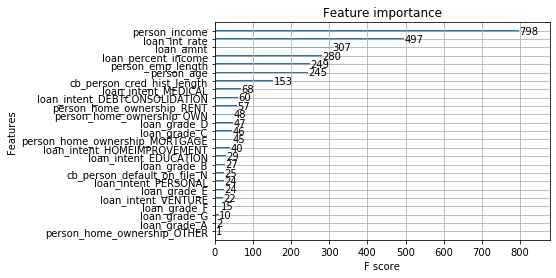

In [15]:
xgb.plot_importance(clf_gbt, importance_type= 'weight')

In [16]:
top_15 = [tup[0] for tup in feature_importance[-15:]]
top_15

['loan_intent_HOMEIMPROVEMENT',
 'person_home_ownership_MORTGAGE',
 'loan_grade_C',
 'loan_grade_D',
 'person_home_ownership_OWN',
 'person_home_ownership_RENT',
 'loan_intent_DEBTCONSOLIDATION',
 'loan_intent_MEDICAL',
 'cb_person_cred_hist_length',
 'person_age',
 'person_emp_length',
 'loan_percent_income',
 'loan_amnt',
 'loan_int_rate',
 'person_income']

In [17]:
# We need to include our response variable to the list
top_15.append('loan_status')

In [18]:
# Split data
X = cr_loan_prep[top_15].drop(['loan_status'], axis=1)
y = cr_loan_prep.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [19]:
display(X_train.shape)
display(y_train.shape)

(20624, 15)

(20624,)

In [20]:
# Initiate classifier
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Print the classification report
gbt_preds = clf_gbt.predict(X_test) #1D array

target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      6934
     Default       0.95      0.73      0.83      1905

    accuracy                           0.93      8839
   macro avg       0.94      0.86      0.89      8839
weighted avg       0.94      0.93      0.93      8839



# Cross Validating

In [22]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

params = {'eval_metric': 'auc', 'objective': 'binary:logistic', 'seed': 123}

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.900397       0.002971       0.894364      0.006421
1        0.909142       0.001991       0.903260      0.007087
2        0.913961       0.001441       0.906905      0.008270
3        0.917208       0.000929       0.909440      0.007899
4        0.921048       0.001072       0.912693      0.007168


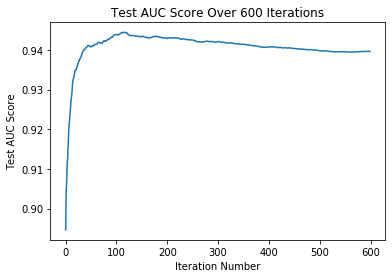

In [23]:
# Limits to CV, what if we increase iterations to 600?

cv_results_big = xgb.cv(params, DTrain, num_boost_round = 600, nfold=10,
            shuffle = True)

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

# Tuning Hyperparameters:

- learning_rate: smaller values make each step more conservative
- max_depth: sets how deep each tree can go, larger means more complex


In [25]:
from sklearn.model_selection import cross_val_score

# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)

# Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

Average accuracy: 0.94 (+/- 0.00)


# Dealing with class imbalance in our loan data

In [53]:
y_train.value_counts()

0    13823
1     3854
Name: loan_status, dtype: int64

In [54]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

In [55]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

1    3854
0    3854
Name: loan_status, dtype: int64


In [59]:
#train/test split undersampled df
X_train_under = X_y_train_under.drop(['loan_status'], axis=1)
y_train_under = X_y_train_under.loan_status

# Initiate classifier
clf_under = xgb.XGBClassifier().fit(X_train_under, np.ravel(y_train_under))

# Predict with undersampled model
gbt2_preds = clf_under.predict(X_test) #1D array

In [61]:
# Compare baseline and undersampled models

# Check the classification reports
target_names = ['Non-Default', 'Default']
print('Baseline model')
print(classification_report(y_test, gbt_preds, target_names=target_names))
print('Undersampled df model')
print(classification_report(y_test, gbt2_preds, target_names=target_names))

Baseline model
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9177
     Default       0.94      0.73      0.82      2609

    accuracy                           0.93     11786
   macro avg       0.94      0.86      0.89     11786
weighted avg       0.93      0.93      0.93     11786

Undersampled df model
              precision    recall  f1-score   support

 Non-Default       0.95      0.91      0.93      9177
     Default       0.72      0.82      0.77      2609

    accuracy                           0.89     11786
   macro avg       0.83      0.86      0.85     11786
weighted avg       0.90      0.89      0.89     11786



In [62]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt_preds))
print(confusion_matrix(y_test,gbt2_preds))

[[9061  116]
 [ 703 1906]]
[[8334  843]
 [ 465 2144]]


In [63]:
# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test, gbt_preds))
print(roc_auc_score(y_test, gbt2_preds))

0.8589539031640963
0.8649553542061695


# Undersampled tree performance

It is even more important that the recall of defaults be high, because a default predicted as non-default is more costly.